https://software.sandia.gov/downloads/pub/coopr/CooprGettingStarted.html

Pyomo supports an object-oriented design for the definition of optimization models. The basic steps of a simple modeling process are:

Create model and declare components

Instantiate the model

Apply solver

Interrogate solver results

In practice, these steps may be applied repeatedly with different data or with different constraints applied to the model. However, we focus on this simple modeling process to illustrate different strategies for modeling with Pyomo.

A Pyomo model consists of a collection of modeling components that define different aspects of the model. Pyomo includes the modeling components that are commonly supported by modern AMLs: index sets, symbolic parameters, decision variables, objectives, and constraints. These modeling components are defined in Pyomo through the following Python classes:

Set
set data that is used to define a model instance

Param
parameter data that is used to define a model instance

Var
decision variables in a model

Objective
expressions that are minimized or maximized in a model

Constraint
constraint expressions that impose restrictions on variable values in a model



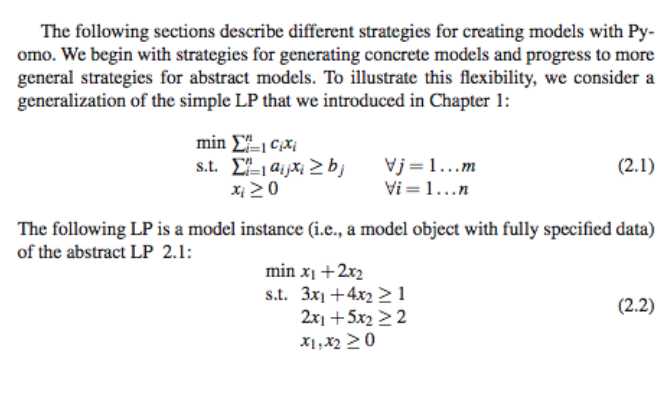

In [1]:
from pyomo.environ import *
from math import pi


# Concrete Pyomo Model with Explicit Variables

In [29]:
m = ConcreteModel()

m.x_1 = Var(within=NonNegativeReals)
m.x_2 = Var(within=NonNegativeReals)

m.obj = Objective(expr= m.x_1 + 2*m.x_2, sense=minimize )

m.c1 = Constraint(expr= 3*m.x_1 + 4*m.x_2 >= 1)
m.c2 = Constraint(expr= 2*m.x_1 + 5*m.x_2 >= 2)

solver = SolverFactory('ipopt')
status = solver.solve(m)

print("Status = %s" % status.solver.termination_condition)

print("%s = %f" % (m.x_1, value(m.x_1)))
print("%s = %f" % (m.x_2, value(m.x_2)))
print("Objective = %f" % value(m.obj))

Status = optimal
x_1 = 0.000000
x_2 = 0.400000
Objective = 0.800000


# Concrete Pyomo Model with Indexed Variables

In [34]:
model = ConcreteModel()
model.x = Var([1,2], within=NonNegativeReals)
model.obj = Objective(expr=model.x[1] + 2*model.x[2])
model.con1 = Constraint(expr=3*model.x[1] + 4*model.x[2]>=1)
model.con2 = Constraint(expr=2*model.x[1] + 5*model.x[2]>=2)

solver = SolverFactory('ipopt')
status = solver.solve(model)

print("Status = %s" % status.solver.termination_condition)

print("%s = %f" % (model.x[1], value(model.x[1])))
print("%s = %f" % (model.x[2], value(model.x[2])))
print("Objective = %f" % value(model.obj))

Status = optimal
x[1] = 0.000000
x[2] = 0.400000
Objective = 0.800000


In [27]:
# Modificando solo el nombre de las variables 
model = ConcreteModel()
model.x = Var([1,3], within=NonNegativeReals)

model.obj = Objective(expr=model.x[1] + 2*model.x[3])

model.con1 = Constraint(expr=3*model.x[1] + 4*model.x[3]>=1)
model.con2 = Constraint(expr=2*model.x[1] + 5*model.x[3]>=2)

solver = SolverFactory('ipopt')
status = solver.solve(model)

print("Status = %s" % status.solver.termination_condition)

print("%s = %f" % (model.x[1], value(model.x[1])))
print("%s = %f" % (model.x[3], value(model.x[3])))
print("Objective = %f" % value(model.obj))

# Concrete Pyomo Model with External Data

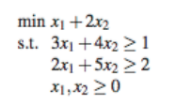

In [39]:
N = [1,2] # Nombre de las variables

c = {1:1, 2:2} # Costos para la funcion de costo 
# Ej. si fuera 5x_1 + 6x_2  tendriamos c = {1:5, 2:6}

a = {(1,1):3, (2,1):4, (1,2):2, (2,2):5} # Parametros de suget to s.t 
# Es una matriz

b = {1:1, 2:2} #  bounds  o cotas

model = ConcreteModel()
model.x = Var(N, within=NonNegativeReals)

model.obj = Objective(expr=sum(c[i]*model.x[i] for i in N))

model.con1 = Constraint(expr=sum(a[i,1]*model.x[i] for i in N) >= b[1])
model.con2 = Constraint(expr=sum(a[i,2]*model.x[i] for i in N) >= b[2])

solver = SolverFactory('ipopt')
status = solver.solve(model)

print("Status = %s" % status.solver.termination_condition)

for i in N:
    print("%s = %f" % (model.x[i], value(model.x[i])))

print("Objective = %f" % value(model.obj))

Status = optimal
x[1] = 0.000000
x[2] = 0.400000
Objective = 0.800000


# Concrete Pyomo Model with Constraint Rules

In [40]:
N = [1,2]
M = [1,2]
c = {1:1, 2:2}
a = {(1,1):3, (2,1):4, (1,2):2, (2,2):5}
b = {1:1, 2:2}

model = ConcreteModel()

model.x = Var(N, within=NonNegativeReals)
model.obj = Objective(expr=sum(c[i]*model.x[i] for i in N))

def con_rule(model, m):
    return sum(a[i,m]*model.x[i] for i in N) >= b[m]

model.con = Constraint(M, rule=con_rule)


solver = SolverFactory('ipopt')
status = solver.solve(model)

print("Status = %s" % status.solver.termination_condition)

for i in N:
    print("%s = %f" % (model.x[i], value(model.x[i])))

print("Objective = %f" % value(model.obj))

Status = optimal
x[1] = 0.000000
x[2] = 0.400000
Objective = 0.800000


#  Concrete Pyomo Model with Abstract Component Declarations

In [42]:
model = ConcreteModel()

def N_rule(model):
    return [1,2]

model.N = Set(rule=N_rule)
model.M = Set(initialize=[1,2])

model.c = Param(model.N, initialize={1:1, 2:2})
model.a = Param(model.N, model.M,initialize={(1,1):3, (2,1):4, (1,2):2, (2,2):5})
model.b = Param(model.M, initialize={1:1, 2:2})

model.x = Var(model.N, within=NonNegativeReals)

# Objective
def obj_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.N)
model.obj = Objective(rule=obj_rule)

# Constraint
def con_rule(model, m):
    return sum(model.a[i,m]*model.x[i] for i in model.N)  >= model.b[m]

model.con = Constraint(model.M, rule=con_rule)



solver = SolverFactory('ipopt')
status = solver.solve(model)

print("Status = %s" % status.solver.termination_condition)

for i in N:
    print("%s = %f" % (model.x[i], value(model.x[i])))

print("Objective = %f" % value(model.obj))

Status = optimal
x[1] = 0.000000
x[2] = 0.400000
Objective = 0.800000


# Using a Function to Construct a Concrete Pyomo Model

In [44]:
def create_model(N=[], M=[], c={}, a={}, b={}):
    model = ConcreteModel()
    model.x = Var(N, within=NonNegativeReals)
    model.obj = Objective(expr=sum(c[i]*model.x[i] for i in N))

    def con_rule(model, m):
        return sum(a[i,m]*model.x[i] for i in N) >= b[m]
    model.con = Constraint(M, rule=con_rule)
    return model

model = create_model(N = [1,2], M = [1,2], c = {1:1, 2:2},
        a = {(1,1):3, (2,1):4, (1,2):2, (2,2):5},
        b = {1:1, 2:2})

solver = SolverFactory('ipopt')
status = solver.solve(model)

print("Status = %s" % status.solver.termination_condition)

for i in N:
    print("%s = %f" % (model.x[i], value(model.x[i])))

print("Objective = %f" % value(model.obj))

Status = optimal
x[1] = 0.000000
x[2] = 0.400000
Objective = 0.800000


# Abstract Pyomo Model

In [50]:
model = AbstractModel()

model.N = Set()
model.M = Set()

model.c = Param(model.N)
model.a = Param(model.N, model.M)
model.b = Param(model.M)

model.x = Var(model.N, within=NonNegativeReals)

def obj_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.N)
model.obj = Objective(rule=obj_rule)

def con_rule(model, m):
    return sum(model.a[i,m]*model.x[i] for i in model.N) >= model.b[m]
model.con = Constraint(model.M, rule=con_rule)

In [51]:
%%writefile info.dat

set N := 1 2 ;
    
set M := 1 2 ;
    
param c :=
1 1
2 2;

param a :=
1 1 3
2 1 4
1 2 2
2 2 5;
param b :=
1 1
2 2 ;

Writing info.dat


In [ ]:
# %load info.dat

set N := 1 2 ;
    
set M := 1 2 ;
    
param c :=
1 1
2 2;

param a :=
1 1 3
2 1 4
1 2 2
2 2 5;
param b :=
1 1
2 2 ;

In [69]:
instance = model.create_instance('info.dat')

#instance.pprint()
opt = SolverFactory("ipopt")
results = opt.solve(instance)
results.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 2
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.018657922744750977
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [65]:
solver = SolverFactory('glpk')

instance = model.create_instance('info.dat')
#results = solver.solve(instance,tee=True)
results = solver.solve(instance)
results.write()
instance.solutions.load_from(results)

for v in instance.component_objects(Var, active=True):
    print ("Variable",v)
    varobject = getattr(instance, str(v))
    for index in varobject:
        print ("   ",index, varobject[index].value)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.8
  Upper bound: 0.8
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 3
  Number of nonzeros: 5
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.016307830810546875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------

In [60]:
instance.solutions.load_from(results)

for v in instance.component_objects(Var, active=True):
    print ("Variable",v)
    varobject = getattr(instance, str(v))
    for index in varobject:
        print ("   ",index, varobject[index].value)

Variable x
    1 0.0
    2 0.4


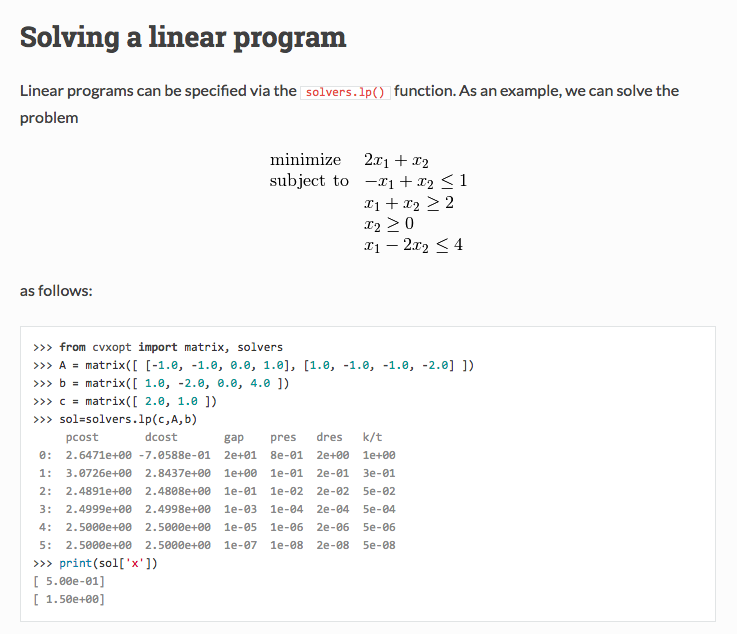

http://cvxopt.org/examples/tutorial/lp.html

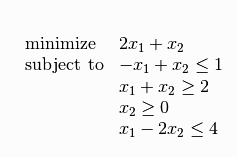

In [73]:
from cvxopt import matrix, solvers

A = matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])

b = matrix([ 1.0, -2.0, 0.0, 4.0 ])

c = matrix([ 2.0, 1.0 ])

sol=solvers.lp(c,A,b)

     pcost       dcost       gap    pres   dres   k/t
 0:  2.6471e+00 -7.0588e-01  2e+01  8e-01  2e+00  1e+00
 1:  3.0726e+00  2.8437e+00  1e+00  1e-01  2e-01  3e-01
 2:  2.4891e+00  2.4808e+00  1e-01  1e-02  2e-02  5e-02
 3:  2.4999e+00  2.4998e+00  1e-03  1e-04  2e-04  5e-04
 4:  2.5000e+00  2.5000e+00  1e-05  1e-06  2e-06  5e-06
 5:  2.5000e+00  2.5000e+00  1e-07  1e-08  2e-08  5e-08
Optimal solution found.


In [74]:
print(sol['x'])

[ 5.00e-01]
[ 1.50e+00]



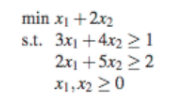

In [76]:
A = matrix([ [-3.0, -2.0, -1.0, 0.0],
             [-4.0, -5.0, 0.0, -1.0] ])

b = matrix([ -1.0, -2.0, 0.0, 0 ])

c = matrix([ 1.0, 2.0 ])

sol=solvers.lp(c,A,b)

print(sol['x'])

     pcost       dcost       gap    pres   dres   k/t
 0:  6.7308e-01  3.7308e+00  6e+00  1e+00  5e+00  1e+00
 1:  8.4233e-01  1.0964e+00  5e-01  1e-01  6e-01  6e-03
 2:  8.0538e-01  8.2298e-01  2e-02  8e-03  4e-02  2e-03
 3:  8.0005e-01  8.0026e-01  2e-04  1e-04  5e-04  3e-05
 4:  8.0000e-01  8.0000e-01  2e-06  1e-06  5e-06  3e-07
 5:  8.0000e-01  8.0000e-01  2e-08  1e-08  5e-08  3e-09
Optimal solution found.
[ 1.86e-08]
[ 4.00e-01]



In [90]:
# Abstract Knapsack Problem
#

from pyomo.environ import *

model = AbstractModel()

model.ITEMS = Set()

model.v = Param(model.ITEMS, within=PositiveReals)

model.w = Param(model.ITEMS, within=PositiveReals)

model.limit = Param(within=PositiveReals)

model.x = Var(model.ITEMS, within=Binary)

def value_rule(model):
    return sum(model.v[i]*model.x[i] for i in model.ITEMS)
model.value = Objective(sense=maximize, rule=value_rule)

def weight_rule(model):
    return sum(model.w[i]*model.x[i] for i in model.ITEMS) <= model.limit
model.weight = Constraint(rule=weight_rule)



data = {
    'ITEMS': {None:('hammer','wrench','screwdriver','towel')},
    'v': {'hammer': 8,
           'wrench': 3,
           'screwdriver': 6,
           'towel': 11,
       },
    'w': { 'hammer': 5,
           'wrench': 7,
           'screwdriver': 4,
           'towel': 3,
       },
    'limit': {None:14},
}
inst = model.create_instance(data={None:data})
inst.pprint()

solver = SolverFactory('glpk')
results = solver.solve(inst)
results.write()
instance.solutions.load_from(results)

for v in instance.component_objects(Var, active=True):
    print ("Variable",v)
    varobject = getattr(instance, str(v))
    for index in varobject:
        print ("   ",index, varobject[index].value)

1 Set Declarations
    ITEMS : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=False, Bounds=None
        ['hammer', 'screwdriver', 'towel', 'wrench']

3 Param Declarations
    limit : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None :    14
    v : Size=4, Index=ITEMS, Domain=PositiveReals, Default=None, Mutable=False
        Key         : Value
             hammer :     8
        screwdriver :     6
              towel :    11
             wrench :     3
    w : Size=4, Index=ITEMS, Domain=PositiveReals, Default=None, Mutable=False
        Key         : Value
             hammer :     5
        screwdriver :     4
              towel :     3
             wrench :     7

1 Var Declarations
    x : Size=4, Index=ITEMS, Domain=Binary
        Key         : Lower : Value : Upper : Fixed : Stale
             hammer :     0 :  None :     1 : False :  True
        screwdriver :     0 :  None :     1 : False :  True
              towel :    

In [79]:
%matplotlib inline

In [83]:
# Example 1 from http://www.mathworks.com/help/matlab/ref/pdepe.html

from pyomo.environ import *
from pyomo.dae import *
from pyomo.opt import SolverFactory
from pyomo.dae.plugins.finitedifference import Finite_Difference_Transformation
from pyomo.dae.plugins.colloc import Collocation_Discretization_Transformation
import math

m = ConcreteModel()
m.t = ContinuousSet(bounds=(0,2))
m.x = ContinuousSet(bounds=(0,1))
m.u = StateVar(m.x,m.t)

m.dudx = DerivativeVar(m.u,wrt=m.x)
m.dudx2 = DerivativeVar(m.u,wrt=(m.x,m.x))
m.dudt = DerivativeVar(m.u,wrt=m.t)

def _pde(m,i,j):
    if i == 0 or i == 1 or j == 0 :
        return Constraint.Skip
    return math.pi**2*m.dudt[i,j] == m.dudx2[i,j]
m.pde = Constraint(m.x,m.t,rule=_pde)

def _initcon(m,i):
    if i == 0 or i == 1:
        return Constraint.Skip
    return m.u[i,0] == sin(math.pi*i)
m.initcon = Constraint(m.x,rule=_initcon)

def _lowerbound(m,j):
    return m.u[0,j] == 0
m.lowerbound = Constraint(m.t,rule=_lowerbound)

def _upperbound(m,j):
    return math.pi*exp(-j)+m.dudx[1,j] == 0
m.upperbound = Constraint(m.t,rule=_upperbound)

m.obj = Objective(expr=1)

# Discretize using Finite Difference Method
discretize = Finite_Difference_Transformation()
disc = discretize.apply(m,nfe=25,wrt=m.x,scheme='BACKWARD')
disc = discretize.apply(disc,nfe=20,wrt=m.t,scheme='BACKWARD',clonemodel=False)

# Discretize using Orthogonal Collocation
#discretize2 = Collocation_Discretization_Transformation()
#disc = discretize2.apply(disc,nfe=10,ncp=3,wrt=m.x,clonemodel=False)
#disc = discretize2.apply(disc,nfe=20,ncp=3,wrt=m.t,clonemodel=False)


solver='ipopt'
opt=SolverFactory(solver)

results = opt.solve(disc,tee=True)
disc.load(results)

#disc.u.pprint()

x = []
t = []
u = []

for i in sorted(disc.x):
    temp=[]
    tempx = []
    for j in sorted(disc.t):
        tempx.append(i)
        temp.append(value(disc.u[i,j]))
    x.append(tempx)
    t.append(sorted(disc.t))
    u.append(temp)


import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.set_xlabel('Distance x')
ax.set_ylabel('Time t')
ax.set_title('Numerical Solution Using Backward Difference Method')
p = ax.plot_wireframe(x,t,u,rstride=1,cstride=1)
fig.show()

NameError: name 'StateVar' is not defined

In [91]:
from pyomo.environ import *

# Creates a list of the Ingredients
Ingredients = ['CHICKEN', 'BEEF', 'MUTTON', 'RICE', 'WHEAT', 'GEL']

# A dictionary of the costs of each of the Ingredients is created
costs = {'CHICKEN': 0.013,
         'BEEF': 0.008,
         'MUTTON': 0.010,
         'RICE': 0.002,
         'WHEAT': 0.005,
         'GEL': 0.001}

# A dictionary of the protein percent in each of the Ingredients is created
proteinPercent = {'CHICKEN': 0.100,
                  'BEEF': 0.200,
                  'MUTTON': 0.150,
                  'RICE': 0.000,
                  'WHEAT': 0.040,
                  'GEL': 0.000}

# A dictionary of the fat percent in each of the Ingredients is created
fatPercent = {'CHICKEN': 0.080,
              'BEEF': 0.100,
              'MUTTON': 0.110,
              'RICE': 0.010,
              'WHEAT': 0.010,
              'GEL': 0.000}

# A dictionary of the fibre percent in each of the Ingredients is created
fibrePercent = {'CHICKEN': 0.001,
                'BEEF': 0.005,
                'MUTTON': 0.003,
                'RICE': 0.100,
                'WHEAT': 0.150,
                'GEL': 0.000}

# A dictionary of the salt percent in each of the Ingredients is created
saltPercent = {'CHICKEN': 0.002,
               'BEEF': 0.005,
               'MUTTON': 0.007,
               'RICE': 0.002,
               'WHEAT': 0.008,
               'GEL': 0.000}

model = ConcreteModel(name="The Whiskas Problem")

model.ingredient_vars = Var(Ingredients, bounds=(0,None), doc="The amount of each ingredient that is used")

model.obj = Objective(expr=sum(costs[i]*model.ingredient_vars[i] for i in Ingredients), doc="Total Cost of Ingredients per can")

model.c0 = Constraint(expr=sum(model.ingredient_vars[i] for i in Ingredients) == 100, doc="PercentagesSum")
model.c1 = Constraint(expr=sum(proteinPercent[i] * model.ingredient_vars[i] for i in Ingredients) >= 8.0, doc="ProteinRequirement")
model.c2 = Constraint(expr=sum(fatPercent[i] * model.ingredient_vars[i] for i in Ingredients) >= 6.0, doc="FatRequirement")
model.c3 = Constraint(expr=sum(fibrePercent[i] * model.ingredient_vars[i] for i in Ingredients) <= 2.0, doc="FibreRequirement")
model.c4 = Constraint(expr=sum(saltPercent[i] * model.ingredient_vars[i] for i in Ingredients) <= 0.4, doc="SaltRequirement")

In [92]:
#inst = model.create_instance(data={None:data})
#inst.pprint()

solver = SolverFactory('glpk')
results = solver.solve(model)
results.write()
instance.solutions.load_from(results)

for v in instance.component_objects(Var, active=True):
    print ("Variable",v)
    varobject = getattr(instance, str(v))
    for index in varobject:
        print ("   ",index, varobject[index].value)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.52
  Upper bound: 0.52
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 7
  Number of nonzeros: 26
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.013257980346679688
# ----------------------------------------------------------
#   Solution Information
# -------------------------------------

In [96]:
%matplotlib notebook

In [100]:
# sodacan.py
from pyomo.environ import *
from math import pi

M = ConcreteModel()
M.r = Var(bounds=(0,None))
M.h = Var(bounds=(0,None))
M.o = Objective(expr=\
        2*pi*M.r*(M.r + M.h))
M.c = Constraint(expr=\
        pi*M.h*M.r**2 == 355)

In [108]:
solver = SolverFactory('ipopt')
status = solver.solve(M)
status.write()

print("Status = %s" % status.solver.termination_condition)
print("%s = %f" % (M.r, value(M.r)))
print("%s = %f" % (M.h, value(M.h)))

print("Objective = %f" % value(M.o))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 2
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.01768207550048828
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Status =

<IPython.core.display.Javascript object>


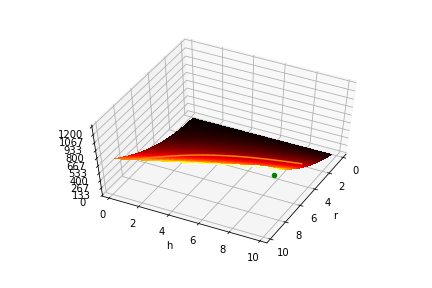

In [115]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sqrt

fig = plt.figure()
ax = fig.gca(projection='3d')
R_ = np.arange(0.25, 10, 0.25)
H_ = np.arange(0.25, 10, 0.25)
R, H = np.meshgrid(R_, H_)
Z = 2*pi*R*(R+H)
surf = ax.plot_surface(R, H, Z, rstride=1, cstride=1, cmap=cm.hot,
                       linewidth=0, antialiased=False)
ax.set_xlabel("r")
ax.set_ylabel("h")
ax.set_zlim(0, 1200)

ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter(' %.02f'))

#fig.colorbar(surf, shrink=0.5, aspect=5)

H_ = 355/(pi*R_*R_)
valid = np.where(H_ < 10.1)
Z_ = R_+H_
Z_ = 2*pi*R_*Z_
ax.plot(R_[valid], H_[valid], Z_[valid], label='parametric curve')
ax.scatter3D(3.837215,7.674430,0,s=20,c="green")
ax.scatter3D?
plt.show()

In [133]:
model = ConcreteModel()

model.x = Var( initialize=-1.2, bounds=(-2, 2) )
model.y = Var( initialize= 1.0, bounds=(-2, 2) )

model.obj = Objective(
expr= (1-model.x)**2 + 100*(model.y-model.x**2)**2,
sense= minimize )

In [135]:
solver = SolverFactory('ipopt')
status = solver.solve(model)
status.write()

print("Status = %s" % status.solver.termination_condition)
print("%s = %f" % (model.x, value(model.x)))
print("%s = %f" % (model.y, value(model.y)))

print("Objective = %f" % value(model.obj))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 2
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.019145965576171875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Status 

In [140]:
print("\nDisplaying Solution\n" + '-'*60)
pyomo_postprocess(None, model, status)


Displaying Solution
------------------------------------------------------------
x : Size=1, Index=None, Domain=Reals
    Key  : Lower : Value              : Upper : Fixed : Stale
    None :    -2 : 0.9999999974823921 :     2 : False : False


In [139]:
## Display of the output ##
# Display x.l, x.m ;
def pyomo_postprocess(options=None, instance=None, results=None):
    model.x.display()

In [141]:
model.x.display()

x : Size=1, Index=None, Domain=Reals
    Key  : Lower : Value              : Upper : Fixed : Stale
    None :    -2 : 0.9999999974823921 :     2 : False : False


In [142]:
model.y.display()

y : Size=1, Index=None, Domain=Reals
    Key  : Lower : Value              : Upper : Fixed : Stale
    None :    -2 : 0.9999999949529991 :     2 : False : False
